# Heart rate estimation from ECG signal

We will be analysing an electrocardiogram signal to estimate the heart rate.

In [1]:
# Import statements
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks


# Loading ecg
from scipy.misc import electrocardiogram
# You can also access it on https://physionet.org/

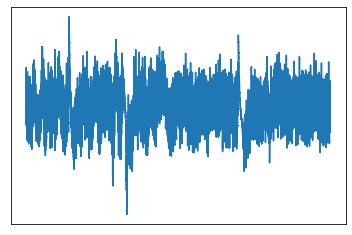

In [2]:
# Example of an ecg signal
ecg_whole = electrocardiogram()
plt.plot(ecg_whole)
plt.gca().axes.xaxis.set_visible(False)
plt.gca().axes.yaxis.set_visible(False)

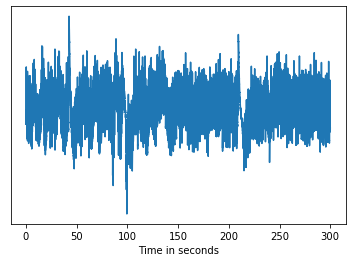

In [3]:
fs = 360 # sampling frequency in Hz

timestamps = np.arange(len(ecg_whole))*1/fs
plt.plot(timestamps, ecg_whole)
plt.xlabel('Time in seconds')
plt.gca().axes.yaxis.set_visible(False)

In [4]:
print("Total signal length: {} minutes".format(np.round(timestamps[-1]/60)))

Total signal length: 5.0 minutes


In [5]:
# We can trim the signal and use only the first part for the next steps
ecg = ecg_whole[0:1000]

## Heart Physiology
### Orgin of the ECG signal 

The heart is made up of four chambers: the left and right atria and the left and right ventricles. The cardiac myocytes that form the heart are electrically excitable. As we all know, the heart pump blood throughout the body to deliver oxygen and nutrients to the tissues and evacuate waste ans towins. This happens in response to electrical excitation. The heart beats in a regular rhythm and is controlled by the electrical conduction system which is composed of specialized cardiac myocytes, called pacemakers.  
The membrane of a cell has channels which open and close according to the voltage. They allow ions to go accross the membrane.
When an electrical excitation arrives, it propagates through the rest of the membrane and changes the ion concentration. At rest, the interior of the cell is positively charged relative to the outside.   
The ECG wave results from the mouvement of ions across the membrane of the cardiac myocytes and can be measured using electrodes on the skin.

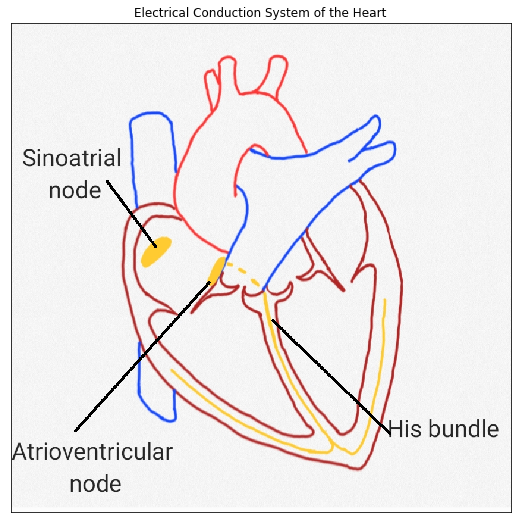

In [6]:
img = plt.imread("data\heart.png") # Own work
plt.figure(figsize=(16, 9))
plt.imshow(img)
plt.title("Electrical Conduction System of the Heart")
plt.gca().axes.xaxis.set_visible(False)
plt.gca().axes.yaxis.set_visible(False)

### QRS complex

The repeating pattern is the QRS complex followed by a P-wave.

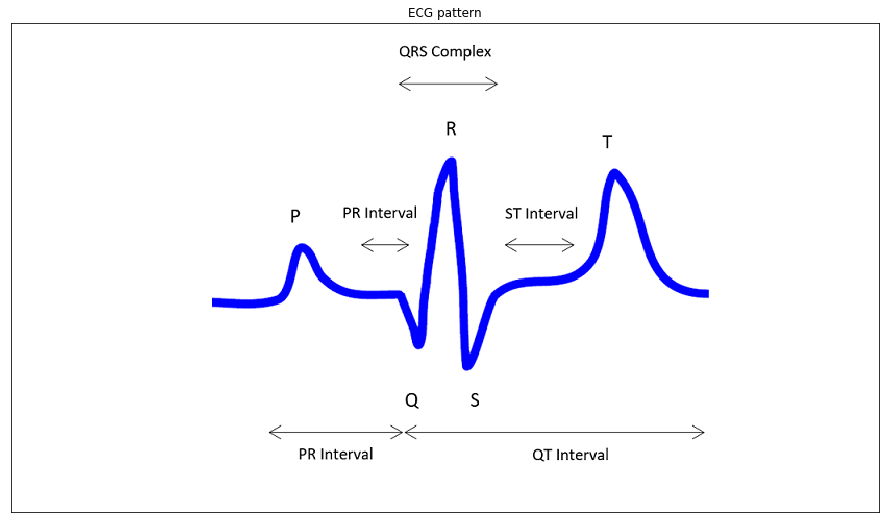

In [7]:
img = plt.imread("data\pattern-ecg.png") # Own work
plt.figure(figsize=(16, 9))
plt.imshow(img)
plt.title("ECG pattern")
plt.gca().axes.xaxis.set_visible(False)
plt.gca().axes.yaxis.set_visible(False)

Let's try to visualize a QRS complex in the signal we have.

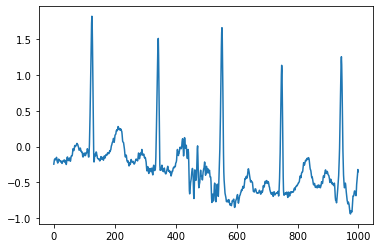

In [8]:
plt.plot(ecg);

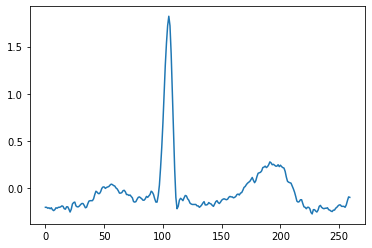

In [9]:
plt.plot(ecg[20:280]);

We can see that noise can alter our signal and change its appearance.

## Heart rate  estimation

### Simple peak detection
We can use the signal in the time domain and detect the R peaks.

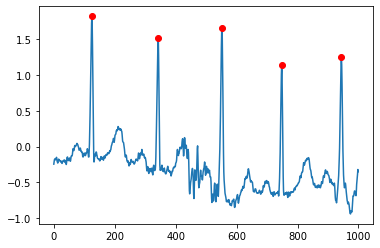

In [10]:
r_peaks, _ = find_peaks(ecg, distance = 150)
plt.plot(ecg)
plt.plot(r_peaks, ecg[r_peaks], 'ro')

In [11]:
print('Average heart rate {:.0f} bpm'.format(np.mean(60/np.diff(r_peaks/fs))))

Average heart rate 106 bpm


>  A normal resting heart rate should be between 60 and 100 beats per minute, which means we are not far off.

Let's use the whole signal to do the same estimation.

In [12]:
r_peaks, _ = find_peaks(ecg_whole, distance = 150)
print('Average heart rate {:.0f} bpm'.format(np.mean(60/np.diff(r_peaks/fs))))

Average heart rate 106 bpm


Having the same result doesn't mean we have a perfect method for heart rate estimation. It might be that our signal was acquired in very good conditions. But, it could also mean the an error compensate another. Let's visualize random windows of our signal to see how our algorithm is doing.

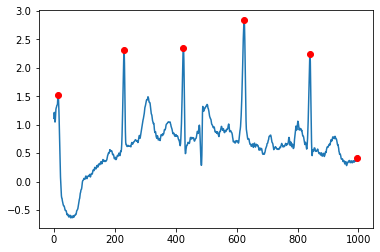

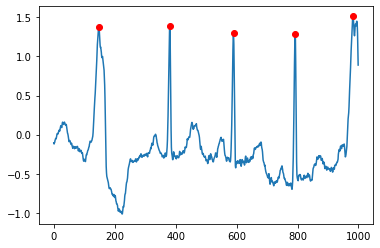

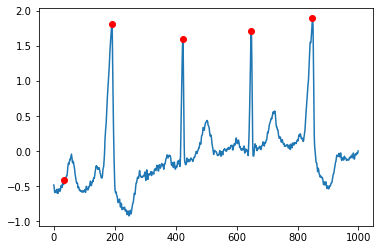

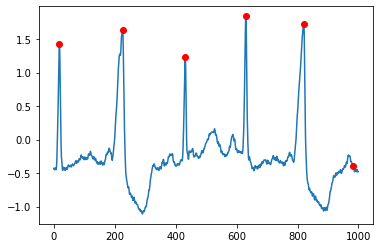

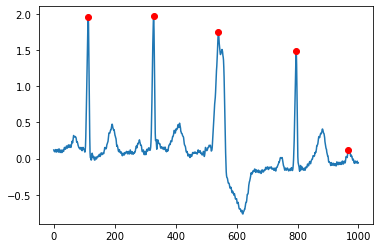

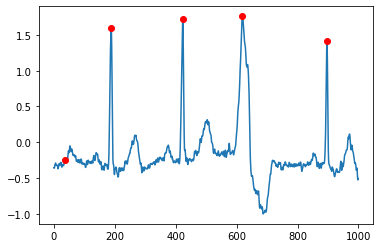

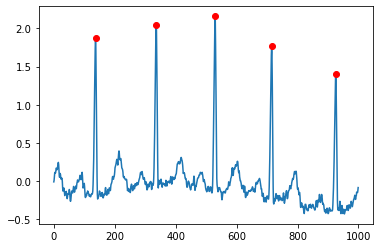

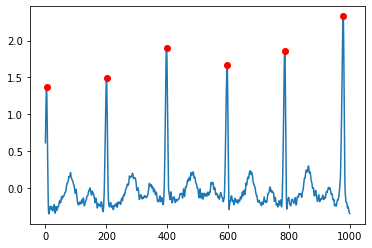

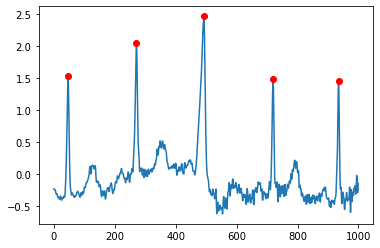

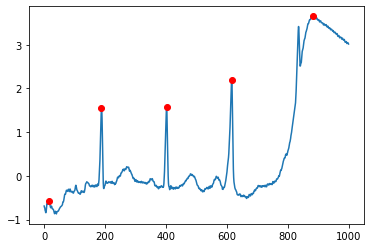

In [13]:
for l in range(10):
    length = 1000
    start = np.random.randint(len(ecg_whole)-length)
    r_peaks, _ = find_peaks(ecg_whole[start:start+length], distance = 150)
    plt.plot(ecg_whole[start:start+length])
    plt.plot(r_peaks, ecg_whole[start:start+length][r_peaks], 'ro')
    plt.show()

Our estimation method is not robust to noise. That is why we will use Pan-Tompkins algorithm

### Pan-Tompkins algorithm

Atrial fibrillation

## References :
[1](https://ieeexplore.ieee.org/abstract/document/7019490) L. Sathyapriya, L. Murali and T. Manigandan, "Analysis and detection R-peak detection using Modified Pan-Tompkins algorithm," 2014 IEEE International Conference on Advanced Communications, Control and Computing Technologies, Ramanathapuram, India, 2014, pp. 483-487, doi: 10.1109/ICACCCT.2014.7019490.  
[2](https://www.coursera.org/learn/physiology) Introductory Human Physiology, Duke University, Coursera.